## Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, normalize

from sklearn.decomposition import PCA 

from pca import pca


from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import pdist, squareform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load data

In [2]:
us_arrests = pd.read_csv("UsArrests.csv")

us_arrests.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Dataset contains 5 variables:
- City: US state (to amend name of column to State) - response variable
- Murder, Assault, Rape: number of arrests per 100 000 residents for each of these crimes - predictor variables
- UrbanPop: percentage of population living in urban areas - predictor variable

## Pre-processing

In [3]:
# rename City column to State
us_arrests.rename(columns = {'City':'State'}, inplace = True)

In [4]:
# get information on the dataset, including datatype of each variable
us_arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Dataset contains 50 rows with non-null values, which also are in an appropriate data type for data analysis.

In [5]:
# check if there are missing values
us_arrests.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

No missing values.

In [6]:
# transform predictor variables to the same datatype for convinience
us_arrests["Assault"] = us_arrests["Assault"].astype("float64")
us_arrests["UrbanPop"] = us_arrests["UrbanPop"].astype("float64")

us_arrests.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [7]:
# get statistical summary of dataset
us_arrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


We can see each variables has distinct features, such as the range of values. We can see this better as a boxplot.

Text(0.5, 1.0, 'US Arrests - Data distribution')

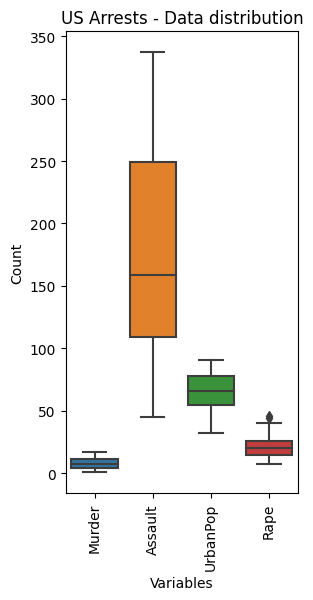

In [8]:
plt.figure(figsize=(3,6))

sns.boxplot(data=us_arrests)

plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("US Arrests - Data distribution")

### Inspect data using a correlation heat map

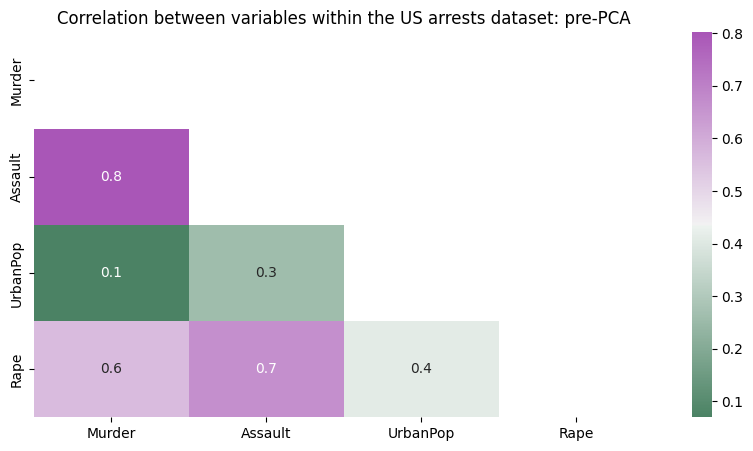

In [9]:
def Corr_map(df, pca_status):    
    correlation = df.corr()

    # create a mask to not show repeated correlation coefficients
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    # Create a custom divergin palette
    cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

    #create plot
    plt.figure(figsize=(10,5))

    sns.heatmap(correlation, mask=mask, annot=True, fmt=".1f", cmap=cmap)

    plt.title(f"Correlation between variables within the US arrests dataset: {pca_status}")

Corr_map(us_arrests, pca_status="pre-PCA")

All variables have positive correlation between each other, meaning as one increases the other will also increase. The variables that show a high correlation are:
- Murder vs Assault
- Murder vs Rape
- Assault vs Rape

These variables might then be considered redundant as they seem to measure the same event. As such, we most likely won't need all three variables for data analysis. Cleaning up redundant variables is of most use in large datasets with many more variables.

We can also see that UrbanPop does not show good correlation with the other variables. However, the unit of measurement is percentage whereas the crime variables are distinct numerical values. As such, it is difficult to compare these variables. Data scaling is then important before proceding to further data analysis.

### Data scaling

In [10]:
# select independent and standardise variables

scaled = StandardScaler().fit_transform(us_arrests.iloc[:,1:5])

# create a scaled version of our dataframe

us_arrests_scaled = pd.DataFrame(scaled, columns = us_arrests.columns[1:5])

us_arrests_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


## Apply PCA

In [11]:
# Show how each variable attributes itself to the explained variance

arrests_PCA = PCA().fit(us_arrests_scaled)

arrests_PCA.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

This shows 62% of variance is explained by the murder variable, 25% by the assault variable, 9% by urban population and 4% by rape. Murder and assault explain a total of 87% of variance. This indicates 2 principal components will most likely be used in our data analysis.

However, we can plot Scree plot and cumulative explained variance plot to visualise this better.

### Create a Scree plot to visualise the cumulative explained variance

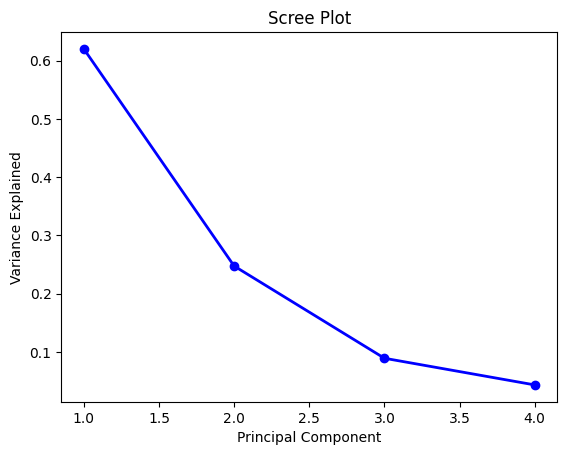

In [12]:
PC_values = np.arange(arrests_PCA.n_components_) + 1
plt.plot(PC_values, arrests_PCA.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Create a cumulative explained variance to better visualise how many principal components to choose for our analysis

Text(3, 86, '85% threshold')

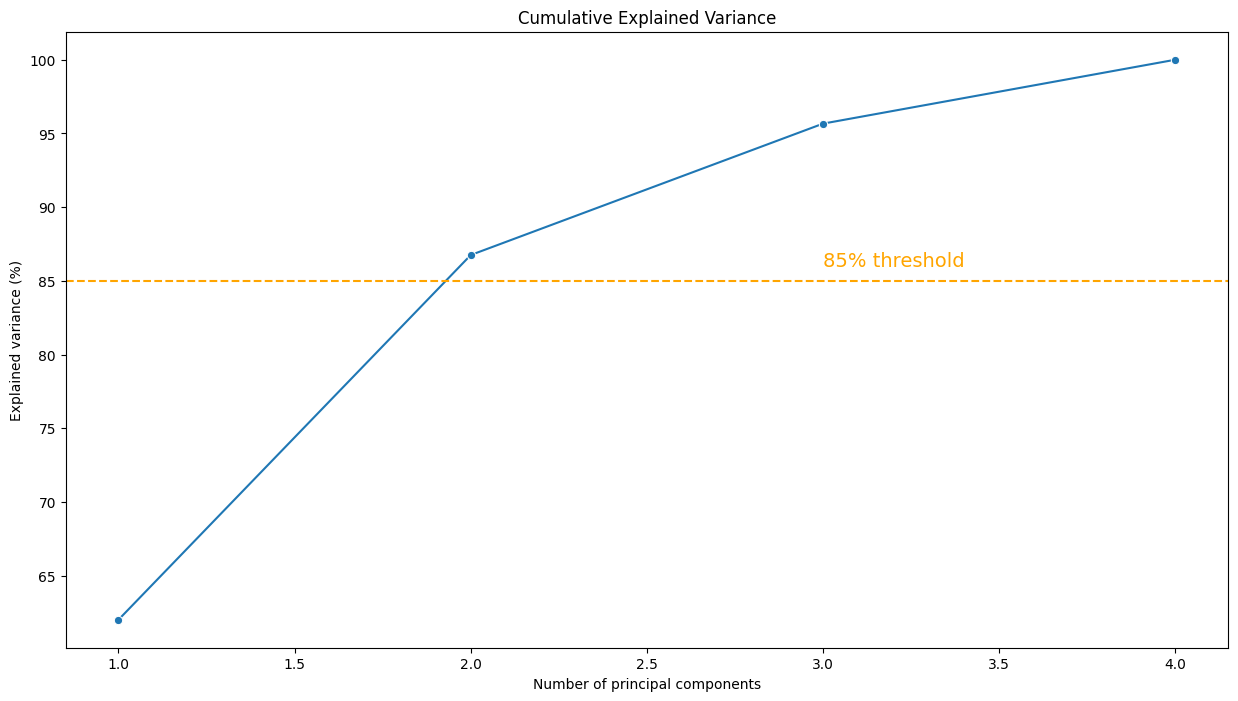

In [13]:
X = np.arange(1, 5, step=1)

plt.figure(figsize=(15,8))

sns.lineplot(x=X, y = np.cumsum(arrests_PCA.explained_variance_ratio_)*100, linestyle="-", marker="o")

plt.title("Cumulative Explained Variance")
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance (%)")
plt.axhline(y=85, color="orange", linestyle="--")
plt.text(3, 86, "85% threshold", color="orange", fontsize=14)


This plot allows us to visualise the explained variance and confirms the minimum number of principal components to use is 2.

### Continuing PCA with 2 components

In [14]:
# choose number of components to be generated
nr_comps = 2
arrests_PCA = PCA(n_components=nr_comps)

# obtain components
principal_components = arrests_PCA.fit_transform(us_arrests_scaled)

principal_components.shape

(50, 2)

In [15]:
# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])

pca_df["State"] = us_arrests["State"]

# This is to include the species as the rownames in the PC's
pca_df.head()

,PC1,PC2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


### Visualising components within the total dataframe by creating a biplot

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


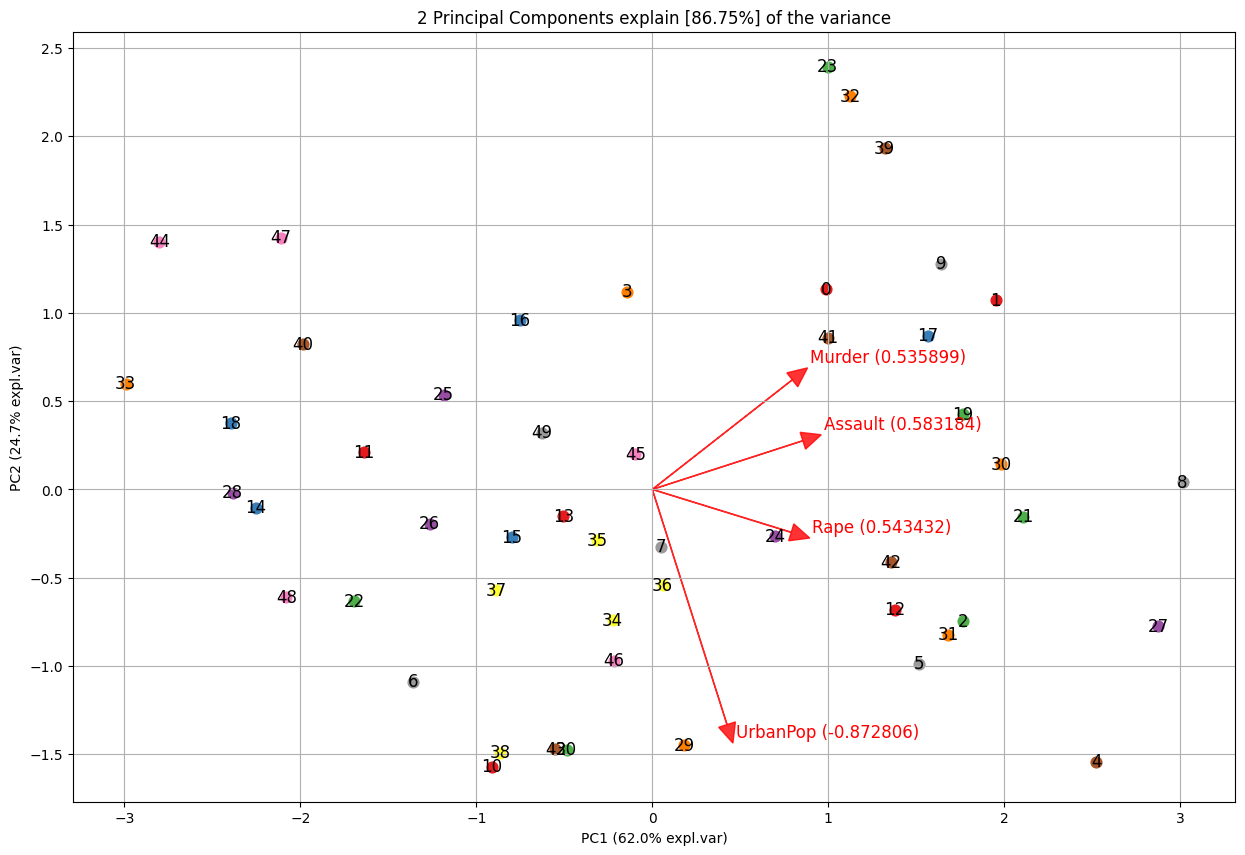

In [16]:
# biplot with total number of variables

model = pca(n_components=2)

results = model.fit_transform(us_arrests_scaled)

fig, ax = model.biplot(n_feat=4, PC=[0,1], legend=False)

This biplot also confirms our previous findings, where PC1 and PC2 together explain 86.75% of the variance, breaking it down to 62% explained by PC1 and 24.7% explained by PC2. The points represent all states and the vectors represent each variable as described above.

All variables have a positive correlation with PC1, with more impact for murder, assault and rape. Regarding PC2, all variables but urban population have a positive correlation. Urban population has a significant negative correlation with PC2.

### Cluster analysis

#### K-means clustering with PCA

We must decide how many clusters needed, by running an algorithm with a different number of clusters. Then, we determine the within cluster sum of squares (wcss) for each solution. This is then plotted and the number of clusters to keep decided using the Elbow-method.

Text(0.5, 1.0, 'K-means with PCA clustering')

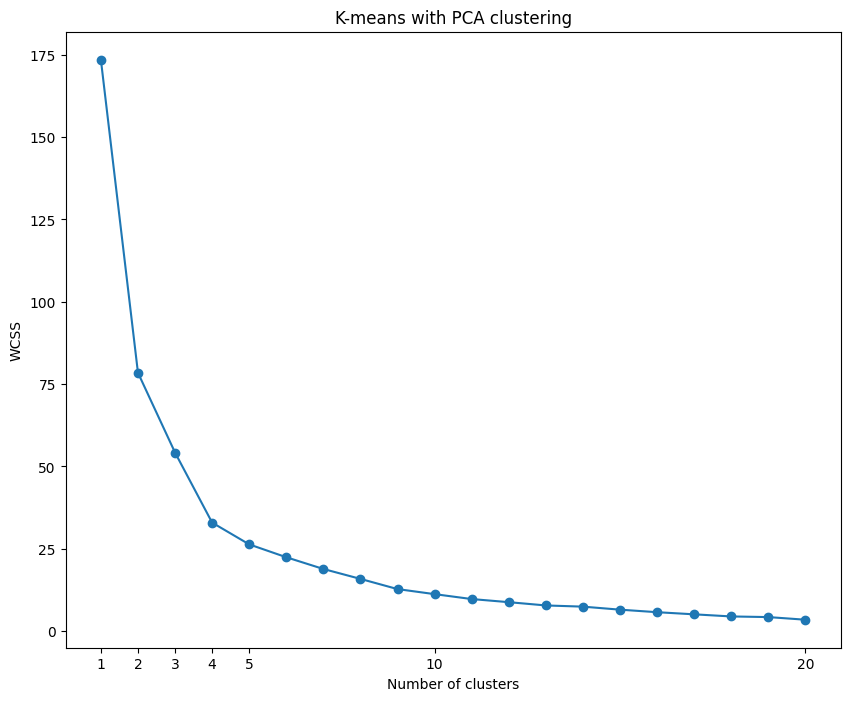

In [17]:
wcss = []

for i in range(1,21):

    kmean_pca = KMeans(n_clusters=i, init = "k-means++", random_state=42)
    kmean_pca.fit(principal_components)
    wcss.append(kmean_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,21),wcss, marker = "o", linestyle="-")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks([1, 2, 3, 4, 5, 10,20])
plt.title("K-means with PCA clustering")

The Elbow-method approach consists of looking for a kink or elbow in the WCSS graph, particularly the part of the graph before the elbow would be steeply declining, while the part after it is much smoother and less steep. In this case, we are looking at 4 clusters.

#### Implementing 4 clusters in K-means method

In [18]:
kmeans_pca = KMeans(n_clusters=4, init="k-means++", random_state=42)

In [20]:
# fit data with kmeans model
kmeans_pca.fit(principal_components)

KMeans(n_clusters=4, random_state=42)

In [21]:
# create a new dataframe with the original variables and add the PCA scores and assigned clusters
new_df1 = pd.concat([us_arrests_scaled.reset_index(drop=True),pd.DataFrame(principal_components)], axis = 1)

new_df1.columns.values[-2:] = ["PC1","PC2"]

# last column added contains the pca k-means clustering labels
new_df1["Segment K-means PCA"] = kmeans_pca.labels_

#### Add the names of the segments to the labels

In [25]:
new_df1["Segment"] = new_df1["Segment K-means PCA"].map({0: "first", 1: "second", 2: "third", 3:"fourth"})

In [26]:
new_df1.head()

,Murder,Assault,UrbanPop,Rape,PC1,PC2,Segment K-means PCA,Segment
0,1.255179,0.790787,-0.526195,-0.003451,0.985566,1.133392,2,third
1,0.513019,1.118060,-1.224067,2.509424,1.950138,1.073213,2,third
2,0.072361,1.493817,1.009122,1.053466,1.763164,-0.745957,0,first
3,0.234708,0.233212,-1.084492,-0.186794,-0.141420,1.119797,2,third
4,0.281093,1.275635,1.776781,2.088814,2.523980,-1.542934,0,first


#### Visualise clusters by principal components

Text(0.5, 1.0, 'K-means clusters by PCA components')

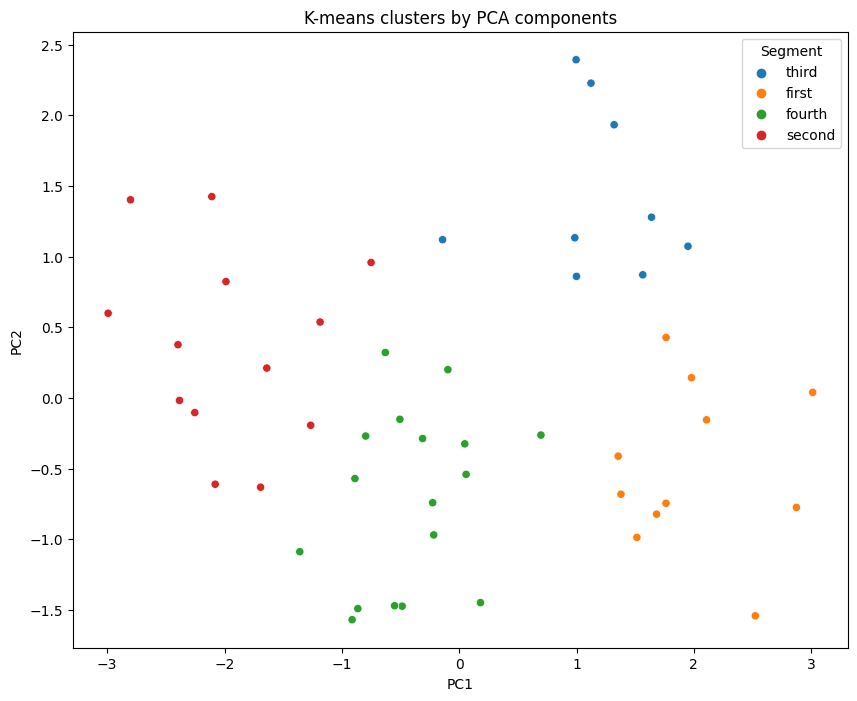

In [29]:
# plot data by PCA components
x_axis = new_df1["PC1"]
y_axis = new_df1["PC2"]
plt.figure(figsize=(10,8))
sns.scatterplot(data = new_df1, x=x_axis, y=y_axis, hue=new_df1["Segment"])
plt.title("K-means clusters by PCA components")

### Agglomerative clustering analysis to visualise later through a dendrogram

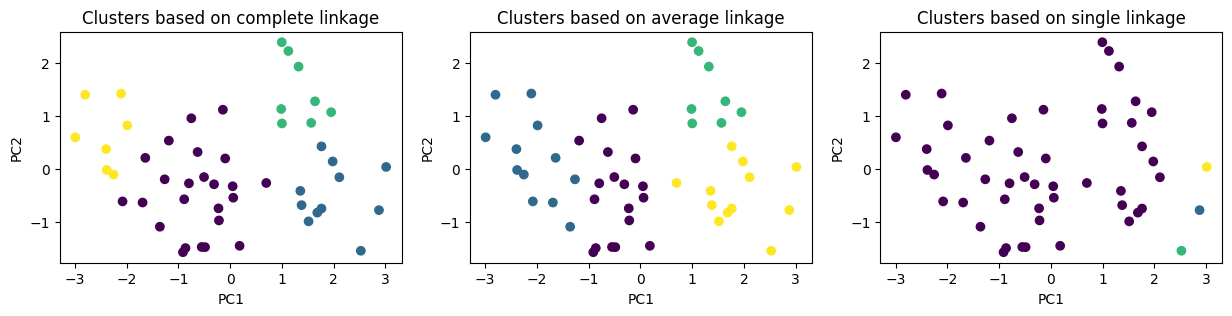

In [33]:
def Clusters (X,K,aff_type):
    plt.figure(figsize=[15,3])

    linkage_types = ['complete', 'average', 'single']

    for i, l in enumerate(linkage_types):
        plt.subplot(1, 3, i+1)
        
        cluster = AgglomerativeClustering(n_clusters=K, metric=aff_type, linkage=l)
        cluster.fit_predict(X)

        ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
        
        plt.title('Clusters based on {} linkage'.format(l))
        plt.xlabel('PC1')
        plt.ylabel('PC2')

Clusters(X = principal_components, K=4, aff_type="euclidean")

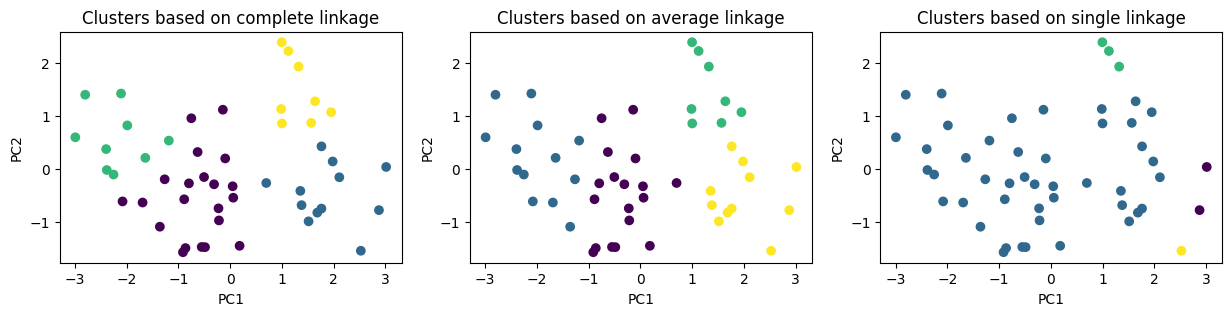

In [34]:
Clusters(X = principal_components, K=4, aff_type="cityblock")

Based on this visualisation, we can see that single linkage in both euclidean and cityblock distance metrics is not good enough to differentiate 4 clusters. Other than that, both complete and average linkage give similar clusters, even when comparing the two different distance metrics methods.

When visually comparing this clustering with the K-means, I would say average linkage with cityblock metrics is the closest clustering combination. As such, I will use this to produce dendrograms.

### Plotting dendrogram

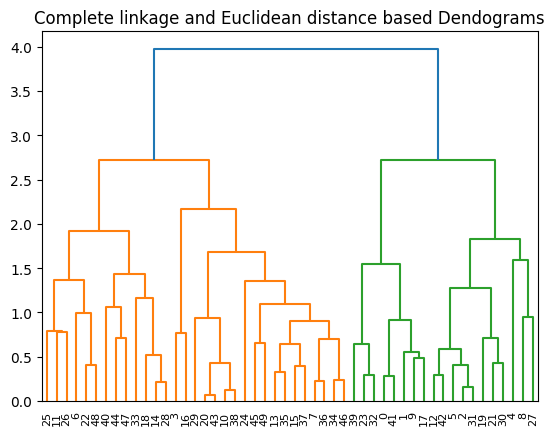

In [35]:
plt.title("Complete linkage and Euclidean distance based Dendograms")  
dend1 = dendrogram(linkage(principal_components, method='average', metric="cityblock"))

From this dendrogram, we see there are two vertical lines, which represent the number of clusters observed by this method. This number will be used in our model below.

### Agglomerative hierarchical clustering with 2 clusterts

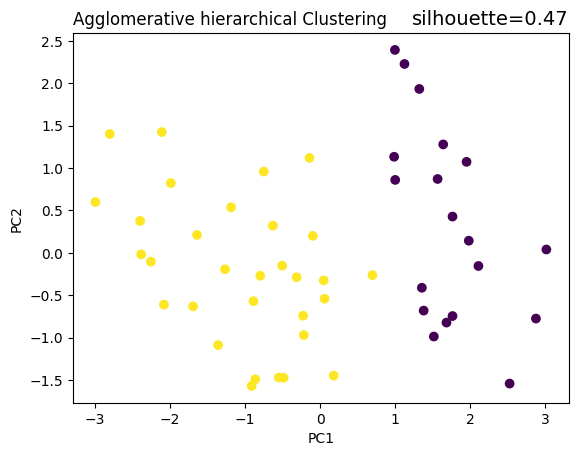

In [40]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='cityblock', linkage="average")
cluster.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=cluster.labels_)

score = round(silhouette_score(principal_components, cluster.labels_, metric='cityblock'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 14}, pad=-14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agglomerative hierarchical Clustering", loc="left")
plt.show()

By using an agglomerative hierarchical clustering method, only two clusters are identified, splitting the data points in half (left and right, at around PC1=1). This supports the variance being explained 62% by PC1 as described previously. On the other hand, the k-means method above identified 4 clusters, which makes me think it a more sensitive method of clustering taking into consideration both principal components.

Github link: https://github.com/TmmSilva/T51.git